# Episode 14 — Controlling Timing and Stretch for Quantum Scheduling

In Qiskit v2.0 you can express **relative timing** using *stretch* variables and let the compiler resolve concrete durations later. This enables patterns like:
- *Match a subcircuit's duration* without knowing gate times in advance.
- *Evenly space* idle intervals between calibrated gates.
- *Left-align* or *right-align* groups of operations between barriers.

We will use:
- `QuantumCircuit.add_stretch(name)` to define a symbolic stretch.
- `QuantumCircuit.delay(stretch_or_duration, qubits)` to insert relative delays.
- Classical expressions from `qiskit.circuit.classical.expr` (e.g., multiply/add constants).
- Barrier regions to define the *window* in which stretch is solved.

> **Key idea**: stretches resolve at compile time, **minimizing** the delays while respecting timing constraints between barriers.

## 0. Imports & Helpers
We keep helpers minimal: drawing circuits and, if installed, inspecting scheduled timing is left to your backend tooling. The examples here focus on **circuit-level** constructs, not backend pulse visuals.

In [25]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
from math import pi
import importlib

have_mpl = importlib.util.find_spec("matplotlib") is not None

def show(qc):
    if have_mpl:
        return qc.draw("mpl", fold=-1, idle_wires=False)
    else:
        print(qc.draw(fold=-1))

## 1) Pattern: Decouple an Idling Qubit While Another Branch Runs

Goal: qubit **q1** is protected via an echo-like sequence (X–delays–X–delays) for **exactly the same length** as a conditional block on **q0**. We do **not** hardcode durations — we stretch the delays to match the subcircuit length between barriers.

> Why two barriers? The solver treats the interval **between consecutive barriers** as a *barrier region*. Stretches are solved with respect to the region they appear in.

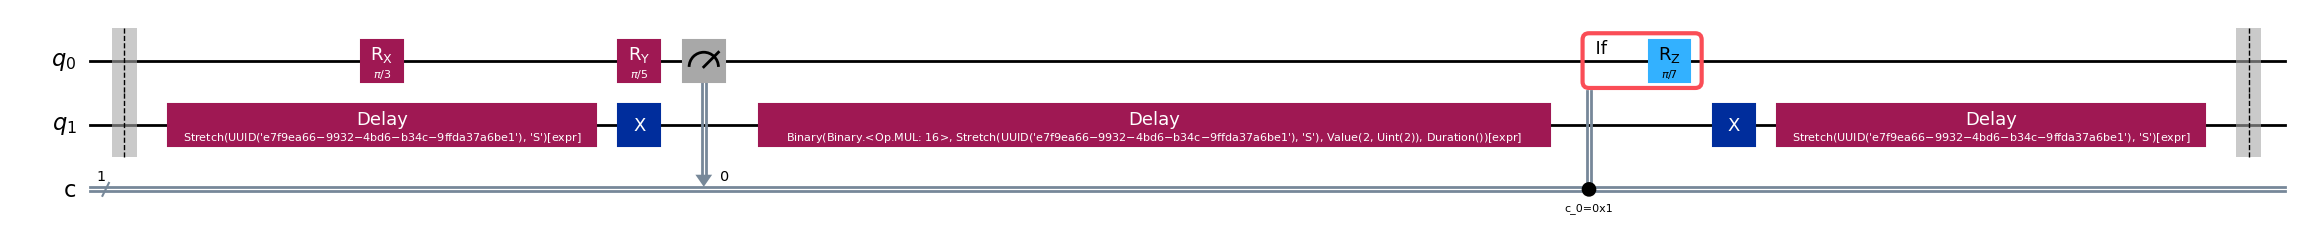

In [26]:
# Registers
q = QuantumRegister(2, "q")
c = ClassicalRegister(1, "c")
qc = QuantumCircuit(q, c)

# Region start: define the timing window
qc.barrier(q)

# Branch on q0 (some calibrated gates + measurement)
qc.rx(pi/3, q[0])      # unknown calibrated duration
qc.ry(pi/5, q[0])      # unknown calibrated duration
qc.measure(q[0], c[0])
with qc.if_test((c[0], 1)):
    qc.rz(pi/7, q[0])  # extra work if 1

# Define a stretch to protect q1 for the whole region
S = qc.add_stretch("S")

# A symmetric X-echo-like sequence on q1
qc.delay(S, q[1])
qc.x(q[1])                # echo 1 (dur known at compile time)
qc.delay(expr.mul(S, 2), q[1])
qc.x(q[1])                # echo 2
qc.delay(S, q[1])

# Region end: solver computes S to span this region
qc.barrier(q)

show(qc)

**What to look for**
- The three delays on `q1` use the **same** stretch variable `S` (with scaling on the middle piece).
- The compiler picks `S` so that the **sum** of delays plus X gate durations **matches** the elapsed time of the `q0` branch.
- This pattern generalizes to more sophisticated decoupling sequences by replacing the two X gates with your calibrated pulses/gates of choice.

## 2) Pattern: Left-Align a Mixed Block of Gates Across Many Qubits

Goal: we have unrelated operations on disjoint qubit sets placed between two barriers. We want them to **start as early as possible** and finish before the end barrier, without knowing exact durations. We place **independent stretches** for each set and let the compiler compute minimal delays to achieve **left alignment**.

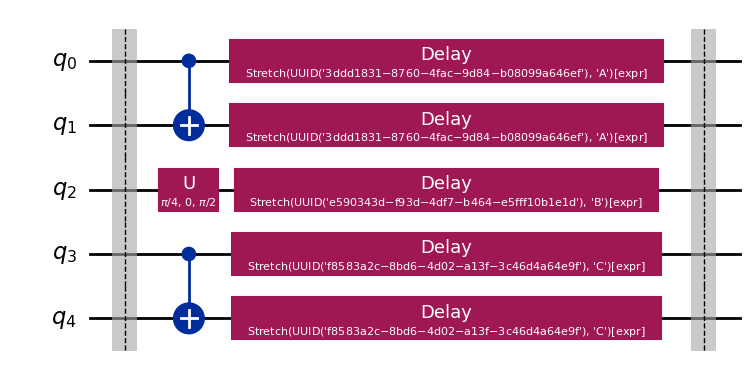

In [28]:
qc2 = QuantumCircuit(5, name="left_align_demo")

# Start the barrier region
qc2.barrier()

# Some mixed work on disjoint sets
qc2.cx(0, 1)          # acts on {0,1}
qc2.u(pi/4, 0.0, pi/2, 2)  # acts on {2}
qc2.cx(3, 4)          # acts on {3,4}

# One stretch per disjoint qubit set
A = qc2.add_stretch("A")
B = qc2.add_stretch("B")
C = qc2.add_stretch("C")

# Use stretches as delays so the compiler can left-align blocks
qc2.delay(A, [0, 1])
qc2.delay(B, 2)
qc2.delay(C, [3, 4])

# Close the region — solver fits A,B,C to the available slack
qc2.barrier()

show(qc2)

**Reading this pattern**
- Each stretch is scoped to the barrier region.
- Stretches are per disjoint qubit set — they can resolve to **different** values depending on actual gate durations.
- This yields minimal idling **at the start** (left alignment) with all blocks finishing before the end barrier.

## 3) Runtime Behavior and Remainders

On some backends, stretch resolution can produce a **remainder** (e.g., if total time isn't divisible by your discrete time unit). A common policy is to add the remainder to the **first** delay using that stretch.

Below is a tiny synthetic example showing how a remainder might be absorbed by the first delay. We *do not* assert specific numbers here (they’re backend-dependent), but the structure is illustrative.

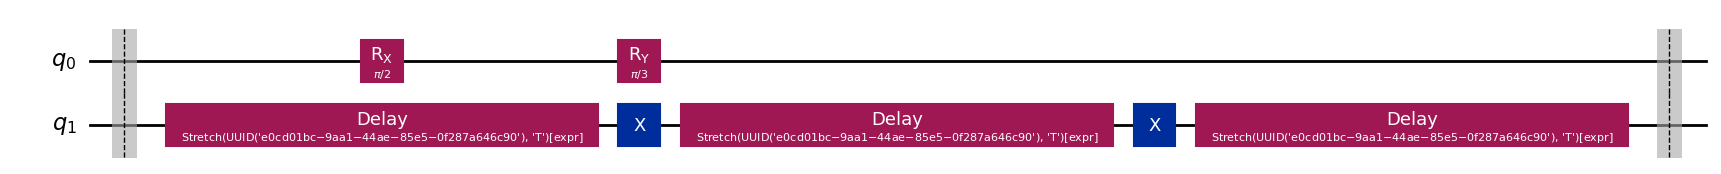

In [71]:
q = QuantumRegister(2, "q")
qc3 = QuantumCircuit(q, name="remainder_demo")

# Region begin
qc3.barrier(q)

# A fixed-duration subcircuit on q0 (placeholder)
qc3.rx(pi/2, q[0])  # assume some calibrated duration
qc3.ry(pi/3, q[0])

# Stretch on q1 used multiple times; solver spreads delays, first may get remainder
T = qc3.add_stretch("T")
qc3.delay(T, q[1])
qc3.x(q[1])
qc3.delay(T, q[1])
qc3.x(q[1])
qc3.delay(T, q[1])

# Region end
qc3.barrier(q)

show(qc3)

## 4) Valid Expressions and Common Pitfalls

Stretch expressions are limited (for hardware compilers to solve efficiently):
- Allowed forms resemble **`X*stretch + Y`**, where X, Y are numeric constants (ints/floats/duration literals).
- Only **one** unique stretch symbol per qubit set within a barrier region.
- A stretch symbol cannot be reused across *different* barrier regions.
- Expressions cannot resolve to **negative** delays.

We’ll demonstrate **valid** vs **invalid** patterns *without* executing the invalid ones.

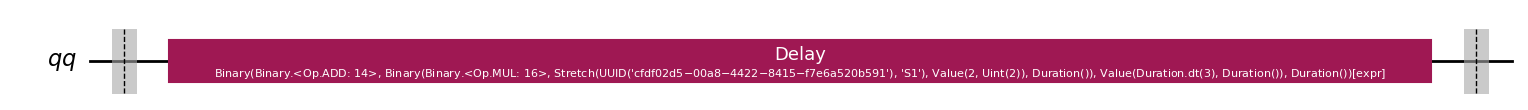

In [74]:
from qiskit.circuit import Duration

# VALID: single stretch with affine combination X*S + Y
qq = QuantumRegister(1, "qq")
qc_ok = QuantumCircuit(qq)
S1 = qc_ok.add_stretch("S1")
qc_ok.barrier(qq)
qc_ok.delay(expr.add(expr.mul(S1, 2), Duration.dt(3)), qq[0])
qc_ok.barrier(qq)
qc_ok.draw("mpl")

# INVALID ideas (commented):
# - Using two different stretches on the same qubit set within a region
# - Non-affine combinations like (S1 / S2) * S3
# - Combining two *different* stretches S1 + S2 in one expression
# - Expressions that would imply negative duration

# These are left as commented guidance to avoid accidental execution:
# bad = QuantumCircuit(1)
# A = bad.add_stretch("A"); B = bad.add_stretch("B")
# bad.barrier(0)
# bad.delay(expr.add(A, B), 0)              # ❌ two stretches mixed
# bad.delay(expr.mul(expr.div(A, B), A), 0)  # ❌ non-affine
# bad.barrier(0)

## 5) Quick Self‑Check

**Q1.** Why do we need barriers when using stretches?

**Q2.** Can two stretches be used on the same qubit within the same barrier region?

**Q3.** What is the typical form of a valid stretch expression on hardware?

**Q4.** If a remainder occurs when resolving stretches, where does it usually go?

<details>
<summary><b>Show answers</b></summary>

- **A1.** Barriers define the *region* whose timing the solver tries to satisfy and minimize. Stretches are solved relative to these boundaries.
- **A2.** No. At most one stretch variable per qubit set in a barrier region.
- **A3.** An affine form like <code>X * stretch + Y</code> with numeric constants.
- **A4.** Many backends add the remainder to the **first** delay that uses that stretch.

</details>

## 6) Mini‑Exercise — Evenly Spaced Echo on Three Qubits

**Challenge:** Between two barriers, you apply a small subcircuit only on qubits `q[0]` and `q[2]`:

1) On `q[0]`: `rx(pi/6)` followed by `rz(pi/8)`.
2) On `q[2]`: `u(pi/5, 0, pi/7)`.

Design stretches so that **q[1]** runs a symmetric echo sequence with three equal delays `D` (i.e., `D – X – D – X – D`) that **exactly spans** the region length. Use only **one** stretch symbol and valid affine expressions.

Hints:
- The two X gates on `q[1]` have calibrated durations; the solver accounts for them.
- Use a single stretch `E` three times with appropriate multipliers (if needed).

In [ ]:
# Your work here — create qc_ex with q[0], q[1], q[2]
q = QuantumRegister(3, "q")
qc_ex = QuantumCircuit(q, name="exercise_even_spacing")

# BEGIN region
qc_ex.barrier(q)

# Subcircuits on q0 and q2 (unknown durations)
qc_ex.rx(pi/6, q[0])
qc_ex.rz(pi/8, q[0])
qc_ex.u(pi/5, 0.0, pi/7, q[2])

# TODO: define a single stretch symbol E and build the symmetric echo on q1

# END region
qc_ex.barrier(q)

show(qc_ex)

<details>
<summary><b>Solution</b></summary>

A valid solution uses **one** stretch variable with **equal** segments:

```python
q = QuantumRegister(3, "q")
sol = QuantumCircuit(q, name="exercise_solution")
sol.barrier(q)
sol.rx(pi/6, q[0]); sol.rz(pi/8, q[0])
sol.u(pi/5, 0.0, pi/7, q[2])
E = sol.add_stretch("E")
sol.delay(E, q[1])
sol.x(q[1])
sol.delay(E, q[1])
sol.x(q[1])
sol.delay(E, q[1])
sol.barrier(q)
show(sol)
```

This produces three equal delays whose combined duration, **plus** the two X gates, matches the barrier region length.

</details>

## 7) Summary & Good Practices

- Use **barriers** to bracket regions where stretches solve.
- Prefer **one** stretch per disjoint qubit set and per region.
- Keep expressions **affine** (like `k*E + c`).
- Remember remainder policies on hardware; the first delay often absorbs it.
- Prototype timing intent with stretches first, then profile on target hardware.

## Additional information

**Created by:** Ricard Santiago Raigada García

**Version:** 1.0.0